EXPERIMENTOS DE CONVERGENCIA

- Problema: PESOS1_UNIFORME -
Numero de puntos: 15000
Dimension: 5
Iteracion 0: f(x) = 189629.308851
Convergencia en iteracion 5
Solucion final: x* = [ 0.12827246 -0.06207801  0.03410811  0.00981173  0.06093667]
Valor objetivo: f(x*) = 189628.790615
Iteraciones: 5
Tiempo total: 6.2037 segundos


- Problema: PESOS1_OUTLIERS -
Numero de puntos: 15000
Dimension: 5
Iteracion 0: f(x) = 312052.770930
Convergencia en iteracion 8
Solucion final: x* = [0.34262287 0.34742115 0.3262791  0.26599925 0.20323601]
Valor objetivo: f(x*) = 278916.743383
Iteraciones: 8
Tiempo total: 5.8240 segundos


- Problema: PESOS1_CLUSTERS -
Numero de puntos: 15000
Dimension: 5
Iteracion 0: f(x) = 358182.053652
Iteracion 10: f(x) = 356924.254508
Convergencia en iteracion 10
Solucion final: x* = [ 5.60415153 -2.66122551 -3.10874885 -8.0432669  -2.49247685]
Valor objetivo: f(x*) = 356924.254508
Iteraciones: 10
Tiempo total: 4.3187 segundos


- Problema: PESOS1_LINEAL -
Numero de puntos: 1

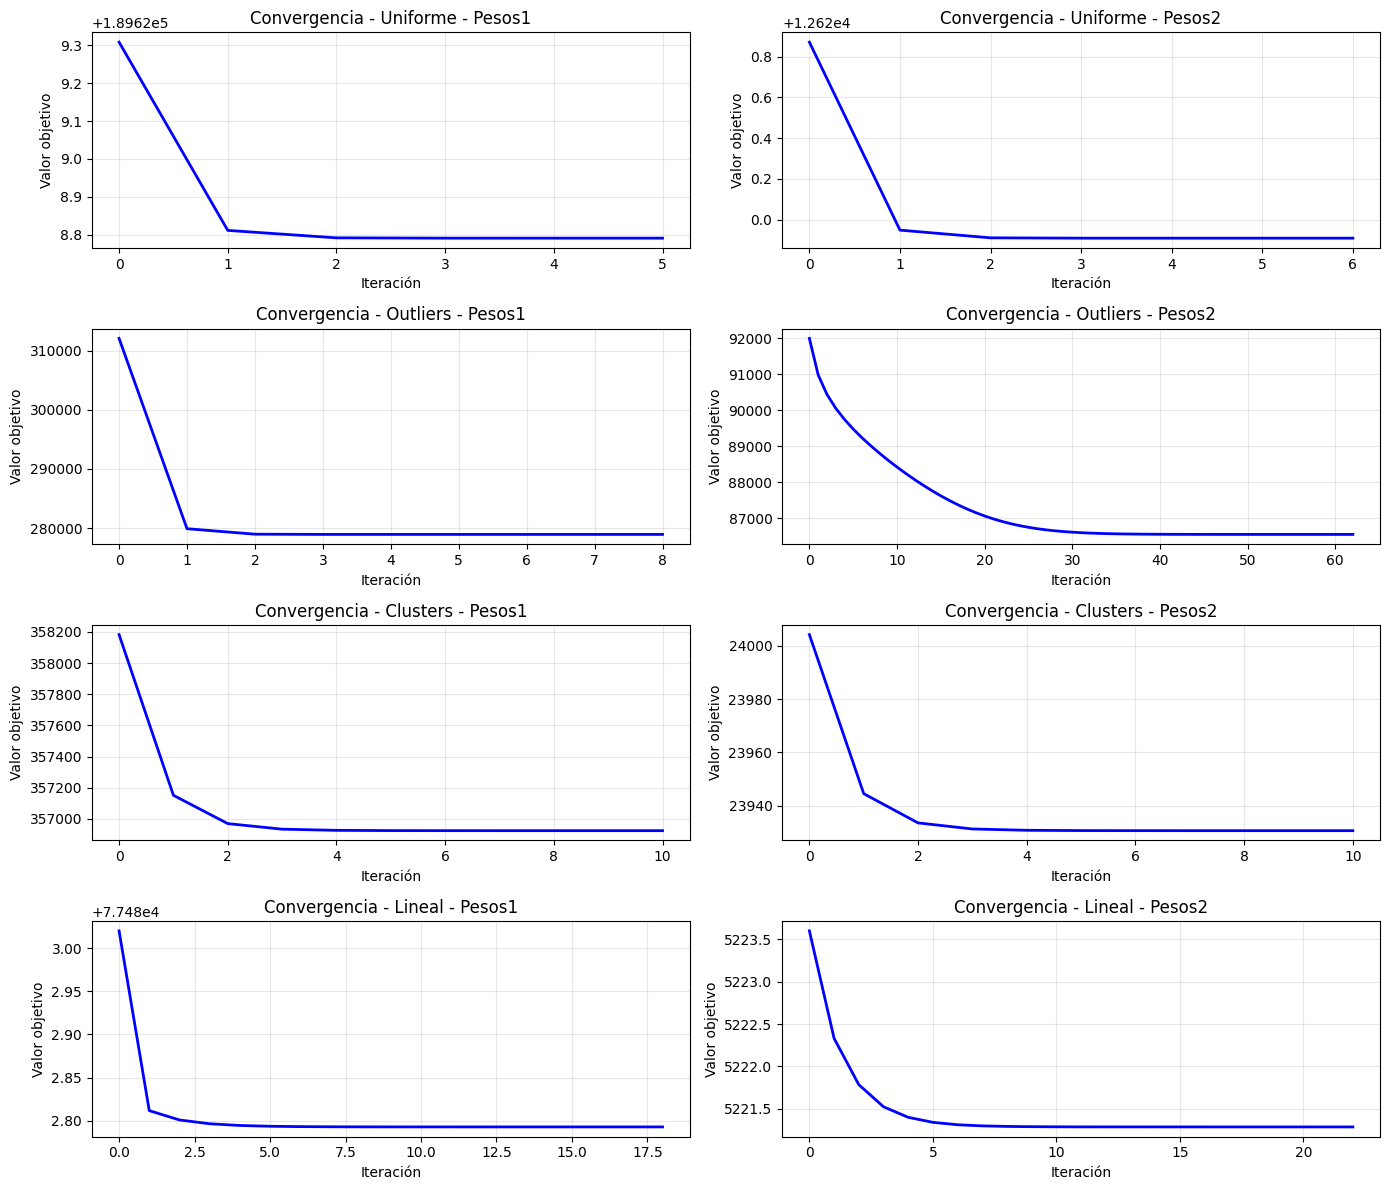


EXPERIMENTOS CON DIFERENTES DIMENSIONES


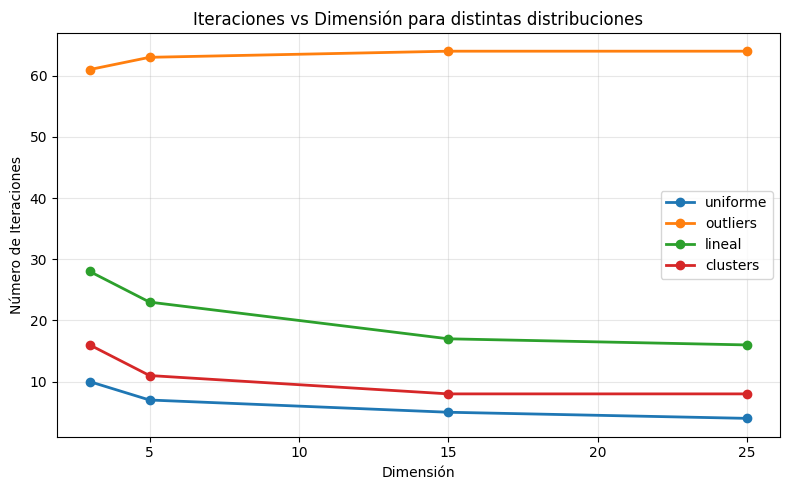

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, List

class FermatWeberSolver:

    def __init__(self, puntos: np.ndarray, pesos: np.ndarray):
        self.puntos = puntos
        self.pesos = pesos
        self.m, self.n = puntos.shape

    def funcion_objetivo(self, x: np.ndarray) -> float:
        distancias = np.linalg.norm(x - self.puntos, axis=1)
        return np.sum(self.pesos * distancias)

    def calcular_Rj(self, j: int) -> np.ndarray:
        pj = self.puntos[j]
        Rj = np.zeros_like(pj)
        for i in range(self.m):
            if i != j:
                diff = pj - self.puntos[i]
                norm = np.linalg.norm(diff)
                if norm > 1e-12:
                    Rj += self.pesos[i] * diff / norm
        return Rj

    def operador_S(self, pj: np.ndarray, Rj: np.ndarray, j: int) -> np.ndarray:
        dj = -Rj / (np.linalg.norm(Rj) + 1e-12)
        suma = 0
        for i in range(self.m):
            if i != j:
                dist = np.linalg.norm(pj - self.puntos[i])
                if dist > 1e-12:
                    suma += self.pesos[i] / dist
        tj = (np.linalg.norm(Rj) - self.pesos[j]) / (suma + 1e-12)
        return pj + tj * dj

    def T(self, x: np.ndarray) -> np.ndarray:
        numerador = np.zeros(self.n)
        denominador = 0.0
        for i in range(self.m):
            diff = x - self.puntos[i]
            dist = np.linalg.norm(diff)
            if dist > 1e-12:
                peso_dist = self.pesos[i] / dist
                numerador += peso_dist * self.puntos[i]
                denominador += peso_dist
        return numerador / denominador

    def weiszfeld(self, x: np.ndarray) -> np.ndarray:
        for j, pj in enumerate(self.puntos):
            if np.allclose(x, pj, atol=1e-8):
                Rj = self.calcular_Rj(j)
                if np.linalg.norm(Rj) <= self.pesos[j]:
                    return pj
                else:
                    s_pj = self.operador_S(pj, Rj, j)
                    if self.funcion_objetivo(s_pj) < self.funcion_objetivo(pj):
                        return s_pj
                    else:
                        return pj
        return self.T(x)

    def solve(self, max_iter: int = 100, tol: float = 1e-4, mostrar: bool = False) -> Tuple[np.ndarray, List[float], List[float]]:
        x = np.mean(self.puntos, axis=0)
        k = 0
        resultados = []
        tiempos = []
        inicio = time.time()

        while k < max_iter:
          actual = self.funcion_objetivo(x)
          if mostrar and k % 10 == 0:
              print(f"Iteracion {k}: f(x) = {actual:.6f}")

          x_new = self.weiszfeld(x)

          resultados.append(actual)
          tiempos.append(time.time() - inicio)

          diff_norm = np.linalg.norm(x_new - x)
          if diff_norm < tol * np.linalg.norm(x):
              if mostrar:
                  print(f"Convergencia en iteracion {k}")
              break

          x = x_new
          k += 1

        if mostrar:
            print(f"Solucion final: x* = {x}")
            print(f"Valor objetivo: f(x*) = {actual:.6f}")
            print(f"Iteraciones: {k}")
            print(f"Tiempo total: {time.time() - inicio:.4f} segundos")

        return x, resultados, tiempos


def generar_datos(d, num_puntos=15000, tipo="uniforme", tipo_pesos=1):
    np.random.seed(45)

    if tipo == "uniforme":
        puntos = np.random.uniform(-10, 10, size=(num_puntos, d))

    elif tipo == "outliers":
        puntos = np.random.normal(0, 5, size=(num_puntos, d))
        num_outliers = int(0.05 * num_puntos)
        puntos[:num_outliers] = np.random.uniform(50, 100, size=(num_outliers, d))

    elif tipo == "lineal":
        direccion = np.random.uniform(-1, 1, size=d)
        direccion = direccion / np.linalg.norm(direccion)
        t = np.random.uniform(-10, 10, size=num_puntos)
        ruido = np.random.normal(0, 0.5, size=(num_puntos, d))
        puntos = np.outer(t, direccion) + ruido

    elif tipo == "clusters":
        num_clusters = 5
        centros = np.random.uniform(-20, 20, size=(num_clusters, d))
        puntos = np.random.normal(
            loc=centros[np.random.choice(num_clusters, num_puntos)],
            scale=2.5, size=(num_puntos, d)
        )

    if tipo_pesos == 1:
        pesos = np.ones(num_puntos)
    else:
        pesos = np.exp(-0.001 * np.arange(num_puntos))

    return puntos, pesos

def problemas():
    problema = {}
    np.random.seed(45)

    problema['pesos1_uniforme'] = generar_datos(5, 15000, "uniforme", 1)
    problema['pesos1_outliers'] = generar_datos(5, 15000, "outliers", 1)
    problema['pesos1_clusters'] = generar_datos(5, 15000, "clusters", 1)
    problema['pesos1_lineal'] = generar_datos(5, 15000, "lineal", 1)

    problema['pesos2_uniforme'] = generar_datos(5, 15000, "uniforme", 2)
    problema['pesos2_outliers'] = generar_datos(5, 15000, "outliers", 2)
    problema['pesos2_clusters'] = generar_datos(5, 15000, "clusters", 2)
    problema['pesos2_lineal'] = generar_datos(5, 15000, "lineal", 2)

    return problema

def experimentos():
    problema = problemas()
    results = {}

    print("EXPERIMENTOS DE CONVERGENCIA\n")

    for nombre, (puntos, pesos) in problema.items():
        print(f"- Problema: {nombre.upper()} -")
        print(f"Numero de puntos: {len(puntos)}")
        print(f"Dimension: {puntos.shape[1]}")

        solver = FermatWeberSolver(puntos, pesos)
        solucion, resultados, tiempos = solver.solve(mostrar=True)

        results[nombre] = {
            'solucion': solucion,
            'resultados': resultados,
            'tiempos': tiempos,
            'puntos': puntos,
            'pesos': pesos
        }
        print("\n" + "="*50 + "\n")

    return results

def graficar(results):
    fig, axes = plt.subplots(4, 2, figsize=(14, 12))

    tipos_pesos = ['pesos1', 'pesos2']
    tipos_dist = ['uniforme','outliers', 'clusters', 'lineal']

    for dist_idx, tipo_dist in enumerate(tipos_dist):
        for peso_idx, tipo_peso in enumerate(tipos_pesos):
            nombre = f"{tipo_peso}_{tipo_dist}"
            datos = results[nombre]
            resultados = datos['resultados']

            ax = axes[dist_idx, peso_idx]
            ax.plot(resultados, 'b-', linewidth=2)
            ax.set_title(f'Convergencia - {tipo_dist.capitalize()} - {tipo_peso.capitalize()}')
            ax.set_xlabel('Iteración')
            ax.set_ylabel('Valor objetivo')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def experimentar_dimensiones(dimensiones: List[int], num_puntos: int = 15000, tipo: str = "uniforme"):
    resultados = []

    for d in dimensiones:
        puntos, pesos = generar_datos(d, num_puntos, tipo, 2)

        solver = FermatWeberSolver(puntos, pesos)
        inicio = time.time()
        solucion, valores, tiempos = solver.solve(mostrar=False)
        tiempo_total = time.time() - inicio

        resultado = {
            'dimension': d,
            'num_puntos': num_puntos,
            'iteraciones': len(valores),
            'valor_final': valores[-1],
            'tiempo_total': tiempo_total,
            'convergencia': valores,
            'solucion': solucion,
            'tipo': tipo
        }

        resultados.append(resultado)

    return resultados


def graficar_resultados_dimensiones(todos_los_resultados):
    plt.figure(figsize=(8, 5))

    for tipo, resultados in todos_los_resultados.items():
        dims = [r['dimension'] for r in resultados]
        iters = [r['iteraciones'] for r in resultados]
        plt.plot(dims, iters, marker='o', linewidth=2, label=tipo)

    plt.title('Iteraciones vs Dimensión para distintas distribuciones')
    plt.xlabel('Dimensión')
    plt.ylabel('Número de Iteraciones')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    results = experimentos()
    graficar(results)

    print("\nEXPERIMENTOS CON DIFERENTES DIMENSIONES")
    dimensiones = [3, 5, 15, 25]
    tipos = ["uniforme", "outliers", "lineal", "clusters"]

    todos_los_resultados = {}

    for tipo in tipos:
        resultados = experimentar_dimensiones(dimensiones, tipo=tipo)
        todos_los_resultados[tipo] = resultados

    graficar_resultados_dimensiones(todos_los_resultados)
